<a href="https://colab.research.google.com/github/dmunozbe/TFM_DataScience/blob/main/Forecasting/08.%20Nou%20Barris/Forecasting_(Indicador_10).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Forecasting**




Forecasting es el proceso de predecir eventos futuros basados en patrones históricos y datos existentes.

El objetivo principal es el de hacer predicciones precisas sobre el futuro utilizando datos pasados y presentes y se utiliza en una amplia variedad de contextos, como en finanzas, meteorologia, ventas entre otros

Se realizaran comprobaciones de cointegracion, estacionariedad, para determinar que modelo aplicar entre los seleccionados:

* Modelos VAR (Vector Autoregressive)
* Modelos VARMA (Vector Autoregressive Moving Average)
* Modelos VARMAx (VARMA con Variables Exógenas)
* Modelos VECM (Vector Error Correlation Model)

##Importar bibliotecas

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn import metrics


import warnings
warnings.filterwarnings("ignore")

##Carga de datos

In [2]:
# Cargar datos
data = pd.read_csv('/content/drive/MyDrive/UOC/TFM/Datasets definitivos/Final.csv')
data.head()

,Any,Trimestre,Mes,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Compraventa_Unitario,ParadosReg,Estudios_Obligatorios,ConsumResidencial,Pm25,Pm10,Participacion,AñosEspVida,Internet,Movil,Index_Turisme,m² por habitante
0,2014,1,1,1,Ciutat Vella,1,el Raval,2813.0,4588,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
1,2014,1,2,1,Ciutat Vella,1,el Raval,2813.0,4539,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
2,2014,1,3,1,Ciutat Vella,1,el Raval,2813.0,4572,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
3,2014,2,4,1,Ciutat Vella,1,el Raval,2948.8,4510,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
4,2014,2,5,1,Ciutat Vella,1,el Raval,2948.8,4379,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2


In [3]:
print(data.dtypes)

Any                        int64
Trimestre                  int64
Mes                        int64
Codi_Districte             int64
Nom_Districte             object
Codi_Barri                 int64
Nom_Barri                 object
Compraventa_Unitario     float64
ParadosReg                 int64
Estudios_Obligatorios    float64
ConsumResidencial        float64
Pm25                     float64
Pm10                     float64
Participacion            float64
AñosEspVida              float64
Internet                 float64
Movil                    float64
Index_Turisme            float64
m² por habitante         float64
dtype: object


## Analisis por grupo de indicadores (Estudios Obligatorios)

### Preparacion de datos

In [4]:
df_sel = data[['Any','Trimestre','Mes','Codi_Districte','Nom_Districte','Codi_Barri','Nom_Barri','Compraventa_Unitario','Estudios_Obligatorios']]

In [5]:
df_cont = df_sel.dropna()

In [6]:
df_cont.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6132 entries, 1752 to 7883
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Any                    6132 non-null   int64  
 1   Trimestre              6132 non-null   int64  
 2   Mes                    6132 non-null   int64  
 3   Codi_Districte         6132 non-null   int64  
 4   Nom_Districte          6132 non-null   object 
 5   Codi_Barri             6132 non-null   int64  
 6   Nom_Barri              6132 non-null   object 
 7   Compraventa_Unitario   6132 non-null   float64
 8   Estudios_Obligatorios  6132 non-null   float64
dtypes: float64(2), int64(5), object(2)
memory usage: 479.1+ KB


In [7]:
# Creamos la variable de fecha de la siguiente manera:
# Agregar un día fijo para cada mes, por ejemplo, el día 1
df_cont['Fecha'] = pd.to_datetime(df_cont['Any'].astype(str) + '-' + df_cont['Mes'].astype(str) + '-1')

In [8]:
# Modificamos el indice del dataset por la fecha
df_contI = df_cont.set_index('Fecha')

In [9]:
df_contI.head()

,Any,Trimestre,Mes,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Compraventa_Unitario,Estudios_Obligatorios
Fecha,,,,,,,,,
2016-01-01,2016,1,1,1,Ciutat Vella,1,el Raval,2813.0,97.2
2016-02-01,2016,1,2,1,Ciutat Vella,1,el Raval,2813.0,97.2
2016-03-01,2016,1,3,1,Ciutat Vella,1,el Raval,2813.0,97.2
2016-04-01,2016,2,4,1,Ciutat Vella,1,el Raval,2948.8,97.2
2016-05-01,2016,2,5,1,Ciutat Vella,1,el Raval,2948.8,97.2


### Analisis Exploratorio

Filtramos los datos por el distrito de Nou Barris -> Codi_Districte = 8

In [10]:
df_contFiltrado = df_contI[df_contI['Codi_Districte'] == 8]

In [11]:
# Agrupamos los datos
df =df_contFiltrado.drop(columns=['Any','Trimestre','Mes','Codi_Districte','Nom_Districte','Codi_Barri','Nom_Barri']).groupby('Fecha').mean()

In [12]:
df.head()

,Compraventa_Unitario,Estudios_Obligatorios
Fecha,,
2016-01-01,1511.900000,94.1
2016-02-01,1511.900000,94.1
2016-03-01,1511.900000,94.1
2016-04-01,1633.069231,94.1
2016-05-01,1633.069231,94.1


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 84 entries, 2016-01-01 to 2022-12-01
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Compraventa_Unitario   84 non-null     float64
 1   Estudios_Obligatorios  84 non-null     float64
dtypes: float64(2)
memory usage: 2.0 KB


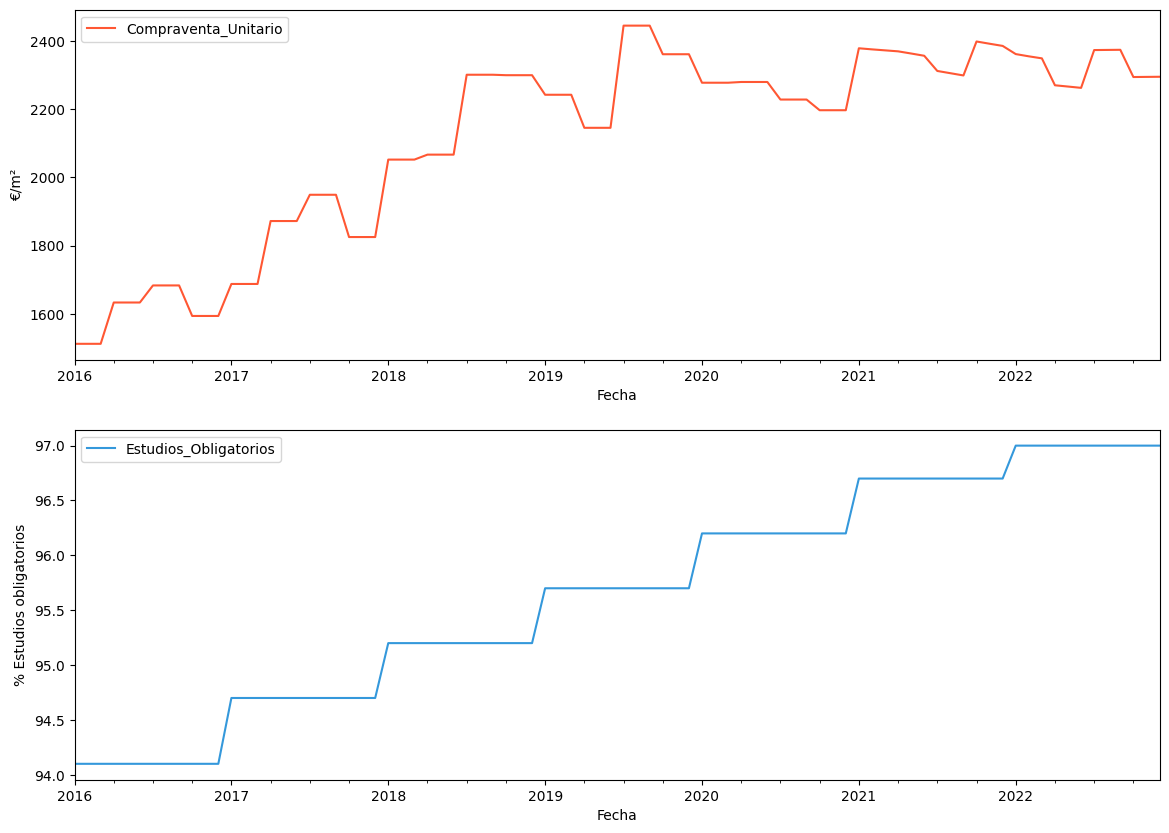

In [14]:
fig, axes = plt.subplots(nrows = int(len(df.columns)), ncols = 1, dpi = 100, figsize = (14,10))
unidades = ['€/m²', '% Estudios obligatorios' ]
colores = ['#FF5733', '#3498DB']

for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df[col].plot(color = colores[i], legend = True, ax = ax)
    ax.set_ylabel(unidades[i])  # Establecer etiqueta del eje y
plt.show()

Ambas series temporales muestran una tendencia al alza

In [15]:
corr=df.corr()
corr

,Compraventa_Unitario,Estudios_Obligatorios
Compraventa_Unitario,1.00000,0.86178
Estudios_Obligatorios,0.86178,1.00000


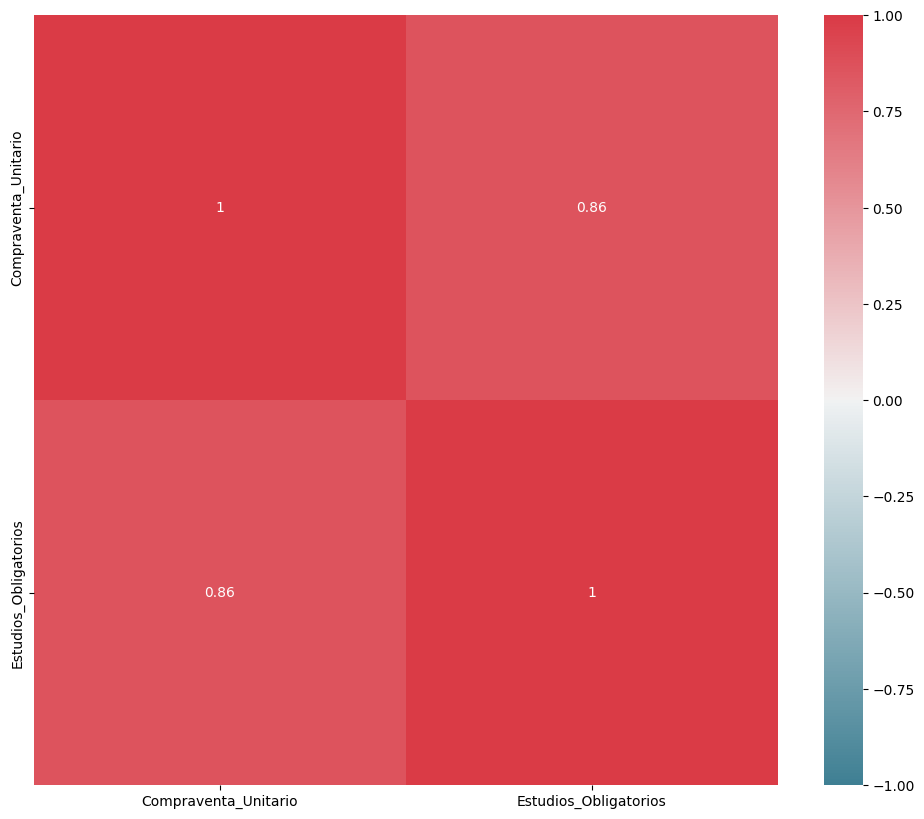

In [16]:
import seaborn as sb
fig, ax = plt.subplots(figsize=(12, 10))

sb.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True,vmax=1, vmin=-1, cmap =sb.diverging_palette(220, 10, as_cmap=True),center=0,ax=ax )
plt.show()

Tambien podemos observar como las 2 variables tienen una alta correlacion, concretamente un 86% de correlacion

### Dividir los datos en conjunto de Entrenamiento y Prueba


In [17]:
fecha_division = '2022-01-01'

X_train, X_test = df[df.index<fecha_division], df[df.index>=fecha_division]
print(X_train.shape, X_test.shape)


(72, 2) (12, 2)


Los modelos siguientes se ajustarán al conjunto de entrenamiento X_train y luego se utilizará el modelo para pronosticar las observaciones futuras. Estos pronósticos se compararán con los datos reales del conjunto de prueba.

###Test de Cointegracion

Determinaremos si las dos variables estan relacionadas entre si y si esa relacion es duradera o no

In [18]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df):
    res = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = res.lr1
    cvts = res.cvt[:, d[str(1-0.05)]]
    def adjust(val, length= 6):
        return str(val).ljust(length)
    print('Column Name   >  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), '> ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [19]:
cointegration_test(X_train[['Compraventa_Unitario','Estudios_Obligatorios']])

Column Name   >  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Compraventa_Unitario >  17.65     > 12.3212   =>   True
Estudios_Obligatorios >  1.8       > 4.1296    =>   False


- **Compraventa_Unitario** muestra evidencia de cointegración, lo que sugiere que las variables incluidas tienen una tendencia a largo plazo a moverse juntas, manteniendo una relación de equilibrio.
- **Estudios_Obligatorios** no muestra evidencia de cointegración, lo que significa que las series relacionadas no tienden a volver a un equilibrio común a largo plazo bajo el modelo actual.

Para un análisis conjunto, dado que una de las series esta cointegrada y la otra no, se consideran principalmente 2 modelos, VAR y VECM

### Prueba de estacionariedad

In [20]:
import statsmodels.tsa.stattools as sts

In [21]:
def augmented_dickey_fuller_statistics(time_series):
  result = sts.adfuller(time_series.values)
  print('p-value: %f' % result[1])

print('Test de Dickey-Fuller Aumentado:')
for i in range(len(X_train.columns)):
  print('Serie de tiempo',X_train.columns[i])
  augmented_dickey_fuller_statistics(X_train.iloc[:,i])

Test de Dickey-Fuller Aumentado:
Serie de tiempo Compraventa_Unitario
p-value: 0.394307
Serie de tiempo Estudios_Obligatorios
p-value: 0.906536


Los p-valores son mayores que 0.05, con lo cual no se rechaza la hipótesis nula de que la serie no es estacionaria. Habría que transformar los datos porque no se puede confirmar estacionariedad.

In [22]:
#Diferenciando por primera vez
X_train_transformed=X_train.diff().dropna()
X_train_transformed.head()

,Compraventa_Unitario,Estudios_Obligatorios
Fecha,,
2016-02-01,0.000000,0.0
2016-03-01,0.000000,0.0
2016-04-01,121.169231,0.0
2016-05-01,0.000000,0.0
2016-06-01,0.000000,0.0


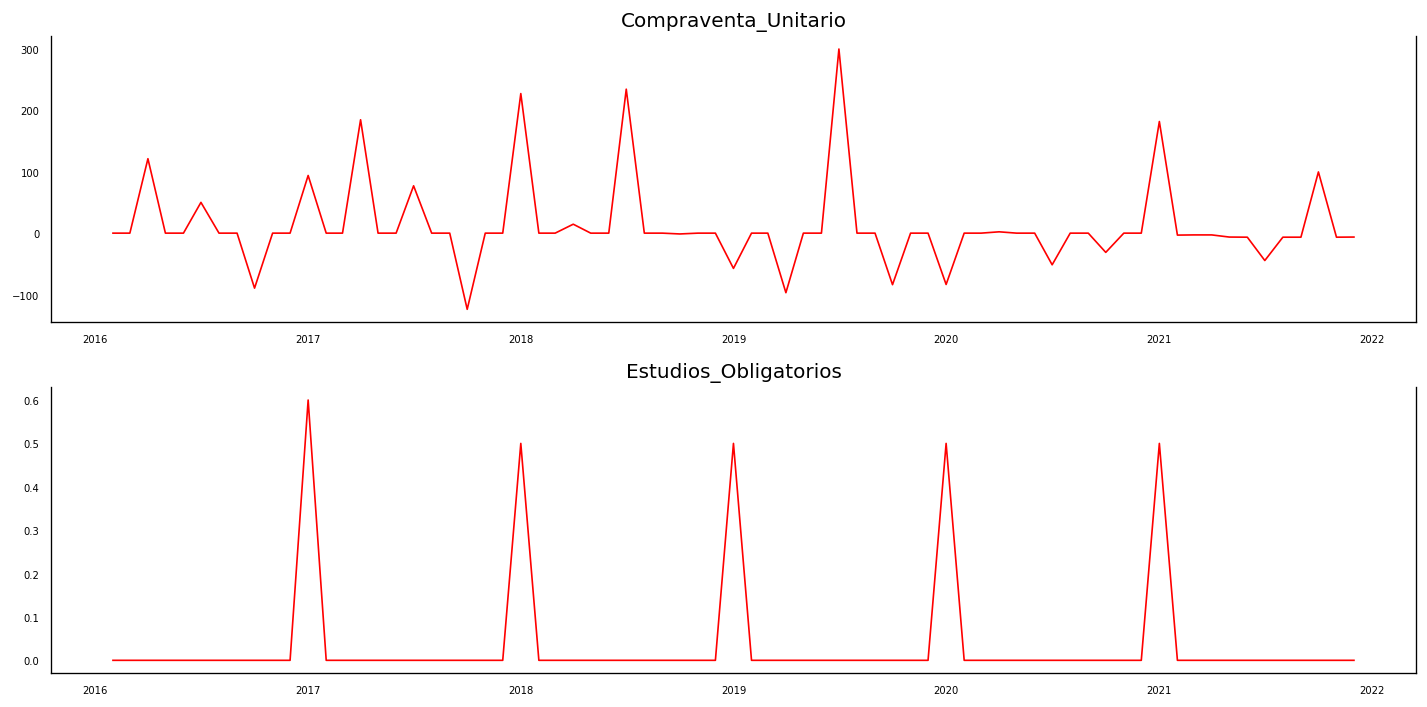

In [23]:
# Plot
fig, axes = plt.subplots(nrows=2, ncols=1, dpi=120, figsize=(12,6))
for i, ax in enumerate(axes.flatten()):
    data = X_train_transformed[X_train_transformed.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(X_train_transformed.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [24]:
print('Test de Dickey-Fuller Aumentado 2da vez:')
for i in range(len(X_train_transformed.columns)):
  print('Serie de tiempo transformada', 'Variable', X_train_transformed.columns[i])
  augmented_dickey_fuller_statistics(X_train_transformed.iloc[:,i])

Test de Dickey-Fuller Aumentado 2da vez:
Serie de tiempo transformada Variable Compraventa_Unitario
p-value: 0.000000
Serie de tiempo transformada Variable Estudios_Obligatorios
p-value: 0.255095


In [25]:
#Diferenciando por segunda vez
X_train_transformed=X_train.diff().diff().dropna()
X_train_transformed.head()

,Compraventa_Unitario,Estudios_Obligatorios
Fecha,,
2016-03-01,0.000000,0.0
2016-04-01,121.169231,0.0
2016-05-01,-121.169231,0.0
2016-06-01,0.000000,0.0
2016-07-01,50.076923,0.0


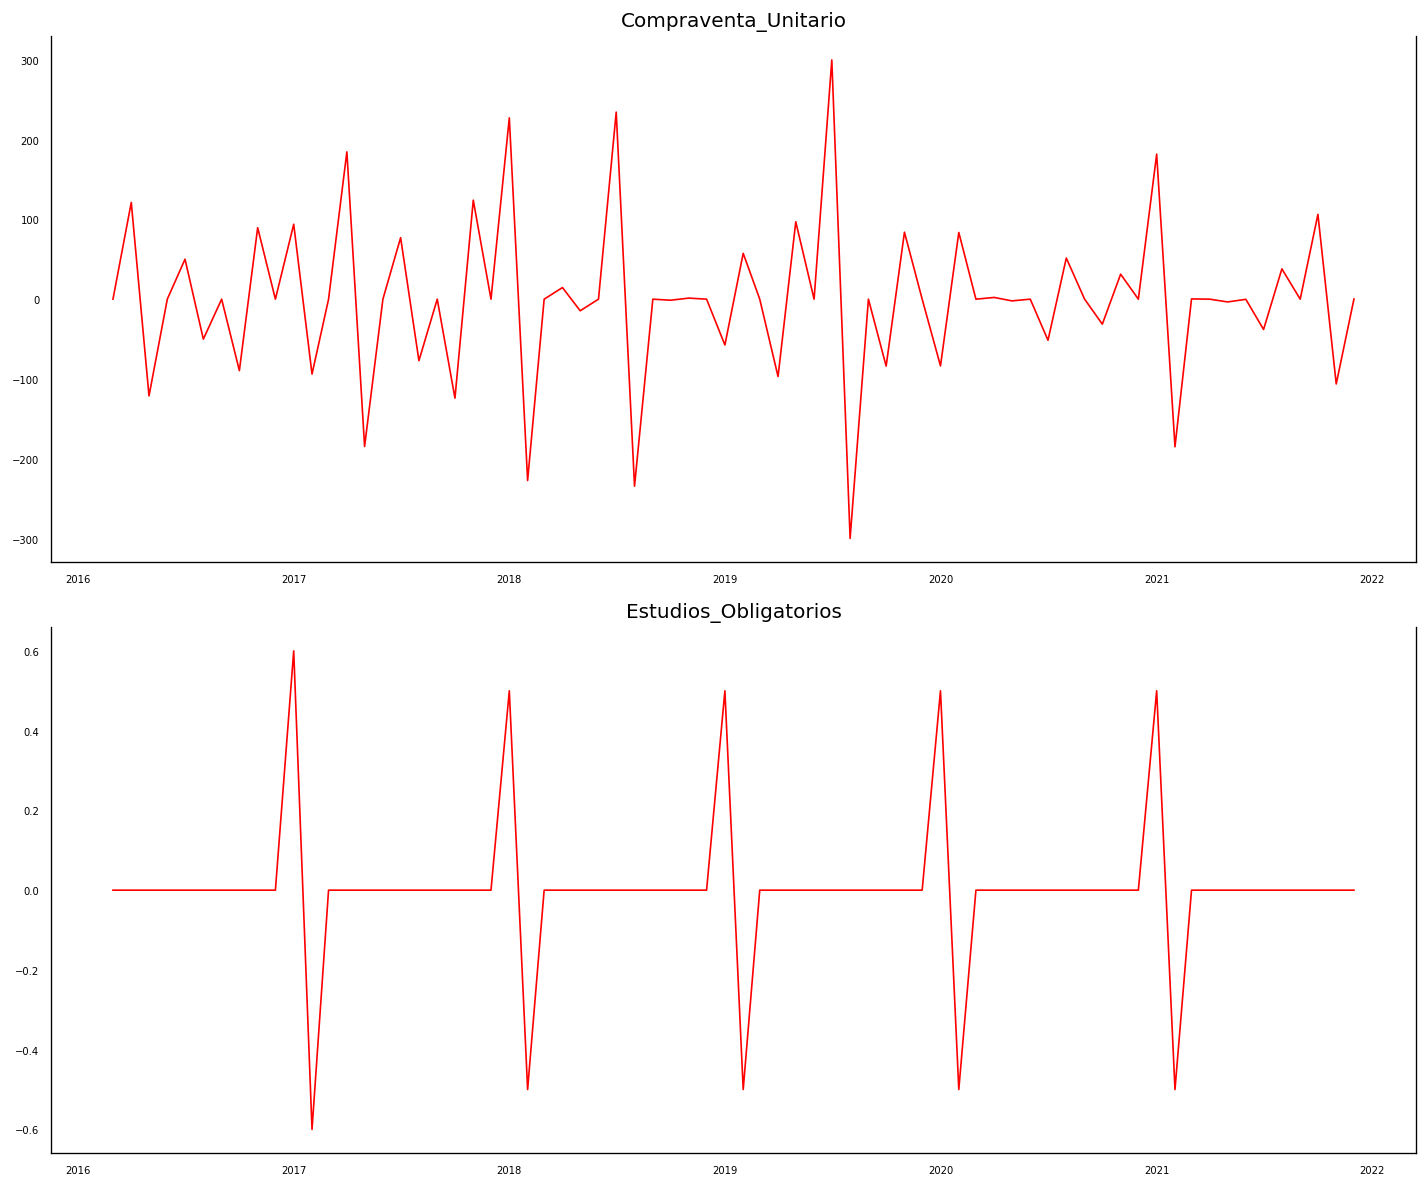

In [26]:
# Plot
fig, axes = plt.subplots(nrows=2, ncols=1, dpi=120, figsize=(12,10))
for i, ax in enumerate(axes.flatten()):
    data = X_train_transformed[X_train_transformed.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(X_train_transformed.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [27]:
print('Test de Dickey-Fuller Aumentado 2da vez:')
for i in range(len(X_train_transformed.columns)):
  print('Serie de tiempo transformada', 'Variable', X_train_transformed.columns[i])
  augmented_dickey_fuller_statistics(X_train_transformed.iloc[:,i])

Test de Dickey-Fuller Aumentado 2da vez:
Serie de tiempo transformada Variable Compraventa_Unitario
p-value: 0.000002
Serie de tiempo transformada Variable Estudios_Obligatorios
p-value: 0.000000


Todos los p-valores son < 0.05 por lo tanto se podría concluir que con 2 ordenes de diferenciación se obtienen series estacionarias.

### Modelo VAR

El modelo VAR es una extension del modelo ARIMA para multiples series temporales, es decir en vez de modelar una sola srie temporal, el VAR modela simultaneamente todas las series temporales de un sistema.
Cada serie temporal se regresa en función de usus propios valores pasados y de los valores pasados de las otras series temporales.
**Es util cuando las diferentes series temporales estan interrelacionadas y se influyen mutuamente.**




In [28]:
from statsmodels.tsa.api import VAR

In [29]:
model = VAR(X_train_transformed)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [30]:
modelsel=model.select_order(22)
modelsel.summary()

,AIC,BIC,FPE,HQIC
0,6.177,6.255,481.4,6.206
1,5.768,6.002,320.0,5.856
2,5.741,6.131,311.8,5.888
3,5.706,6.252,301.9,5.912
4,5.762,6.464,320.8,6.027
5,5.489,6.347,246.1,5.813
6,5.438,6.451,236.4,5.821
7,5.502,6.672,256.0,5.944
8,5.470,6.795,253.1,5.971
9,5.609,7.090,298.9,6.169


Dado que cada criterio sugiere un orden diferente, la elección puede depender del equilibrio deseado entre complejidad del modelo y ajuste a los datos. Si la prioridad es prevenir el sobreajuste y seleccionar un modelo más generalizable, el BIC es más relevante y sugiere un orden de 11. Si se busca un ajuste más cercano a los datos de muestra, considerando la complejidad del modelo, el AIC y HQIC sugieren un orden más alto de 20.

Probamos primero con orden 11

#### Ajustando el modelo

In [31]:
res = model.fit(maxlags=11)
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 15, May, 2024
Time:                     10:04:16
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    2.08215
Nobs:                     59.0000    HQIC:                   1.09467
Log likelihood:          -135.075    FPE:                    1.73230
AIC:                     0.462371    Det(Omega_mle):        0.896808
--------------------------------------------------------------------
Results for equation Compraventa_Unitario
                               coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------
const                             0.429125        10.208083            0.042           0.966
L1.Compraventa_Unitario          -0.886792         0.163970           -5.408           0.0

In [32]:
res.is_stable()

True

In [33]:
X_train.columns

Index(['Compraventa_Unitario', 'Estudios_Obligatorios'], dtype='object')

###### Causalidad de Granger

In [34]:
grangercaus=res.test_causality(['Estudios_Obligatorios'],['Compraventa_Unitario'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
0.7283,1.924,0.708,"(11, 72)"


In [35]:
grangercaus=res.test_causality(['Compraventa_Unitario'],['Estudios_Obligatorios'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
0.9890,1.924,0.465,"(11, 72)"


Como se puede observar, la causalidad de Granger nos indica que ninguna de las series temporales puede predecir la otra serie temporal

###### Matriz de causalidad de Granger


In [36]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests
import warnings
warnings.filterwarnings("ignore")
maxlag=20
test = 'ssr_chi2test'
def grangers_causality_matrix(X_train_transformed, variables, test = 'ssr_chi2test', verbose=False):
  dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
  for c in dataset.columns:
    for r in dataset.index:
      test_result = grangercausalitytests(X_train_transformed[[r,c]], maxlag=maxlag, verbose=False)
      p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
      if verbose:
        print(f'Y = {r}, X = {c}, P Values = {p_values}')
      min_p_value = np.min(p_values)
      dataset.loc[r,c] = min_p_value
  dataset.columns = [var + '_x' for var in variables]
  dataset.index = [var + '_y' for var in variables]
  return dataset
grangers_causality_matrix(X_train_transformed, variables = X_train_transformed.columns)

,Compraventa_Unitario_x,Estudios_Obligatorios_x
Compraventa_Unitario_y,1.0,0.0001
Estudios_Obligatorios_y,0.0,1.0000


Con esta matriz queda claro que la serie temporal de Compraventa_Unitario no causa ni es causada por la otra serie temporal de Estudios_Obligatorios

#### Diagnosis del modelo


###### Residuos

In [37]:
residuals=res.resid

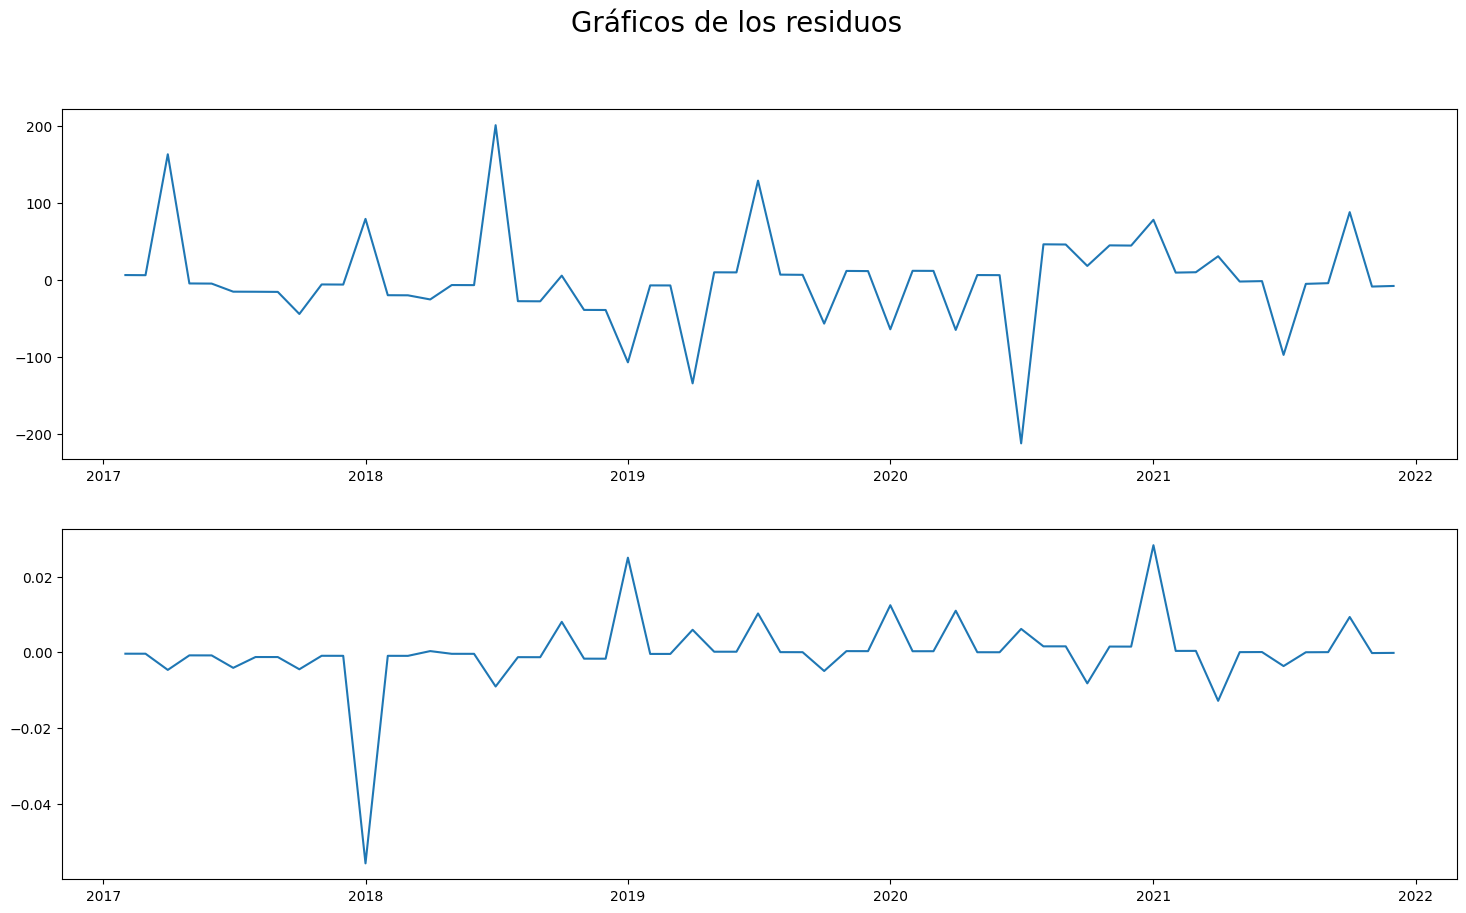

In [38]:
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los residuos',fontsize=20)
fig.set_size_inches(18, 10)
[axs[i].plot(residuals.iloc[:,i]) for i in range(2)]
plt.show()

###### Dickey - Fuller a los residuos


In [39]:
print('ADF de los Residuos, p-valores:')
[sts.adfuller(residuals.iloc[:,i])[1] for i in range(2)]

ADF de los Residuos, p-valores:


[3.3533541293268784e-11, 1.1643287932497584e-10]

Todos los p-valores son < 0.1 por tanto se rechaza la hipótesis nula de que las 2 series de residuos no son estacionarias, por lo cual con un 90% de confianza se cree que son estacionarias.



###### ACF de los Residuos


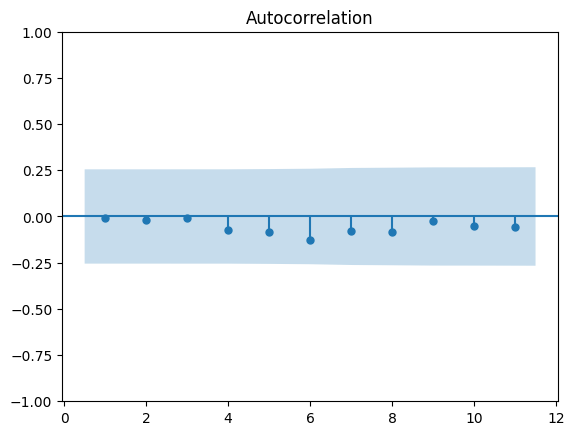

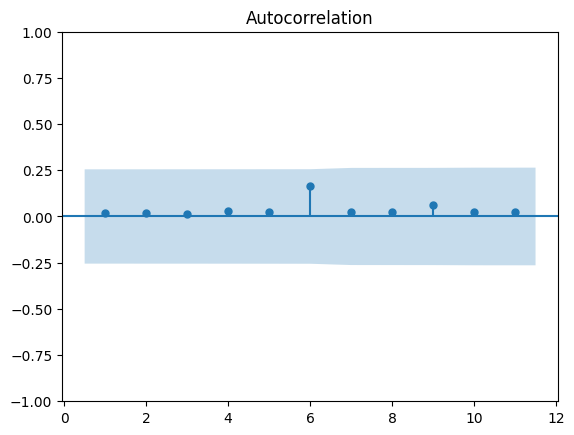

In [40]:
import statsmodels.graphics.tsaplots as sgt
[sgt.plot_acf(residuals.iloc[:,i], zero = False, lags = 11) for i in range(2)]
plt.show()

Se observa que casi los puntos están dentro del intervalo de confianza hasta el rezago 11, lo que sugiere que no hay autocorrelaciones significativas para esos rezagos. Esto es un buen indicio y sugiere que el modelo está adecuadamente especificado para estos rezagos.

#### Valores predichos


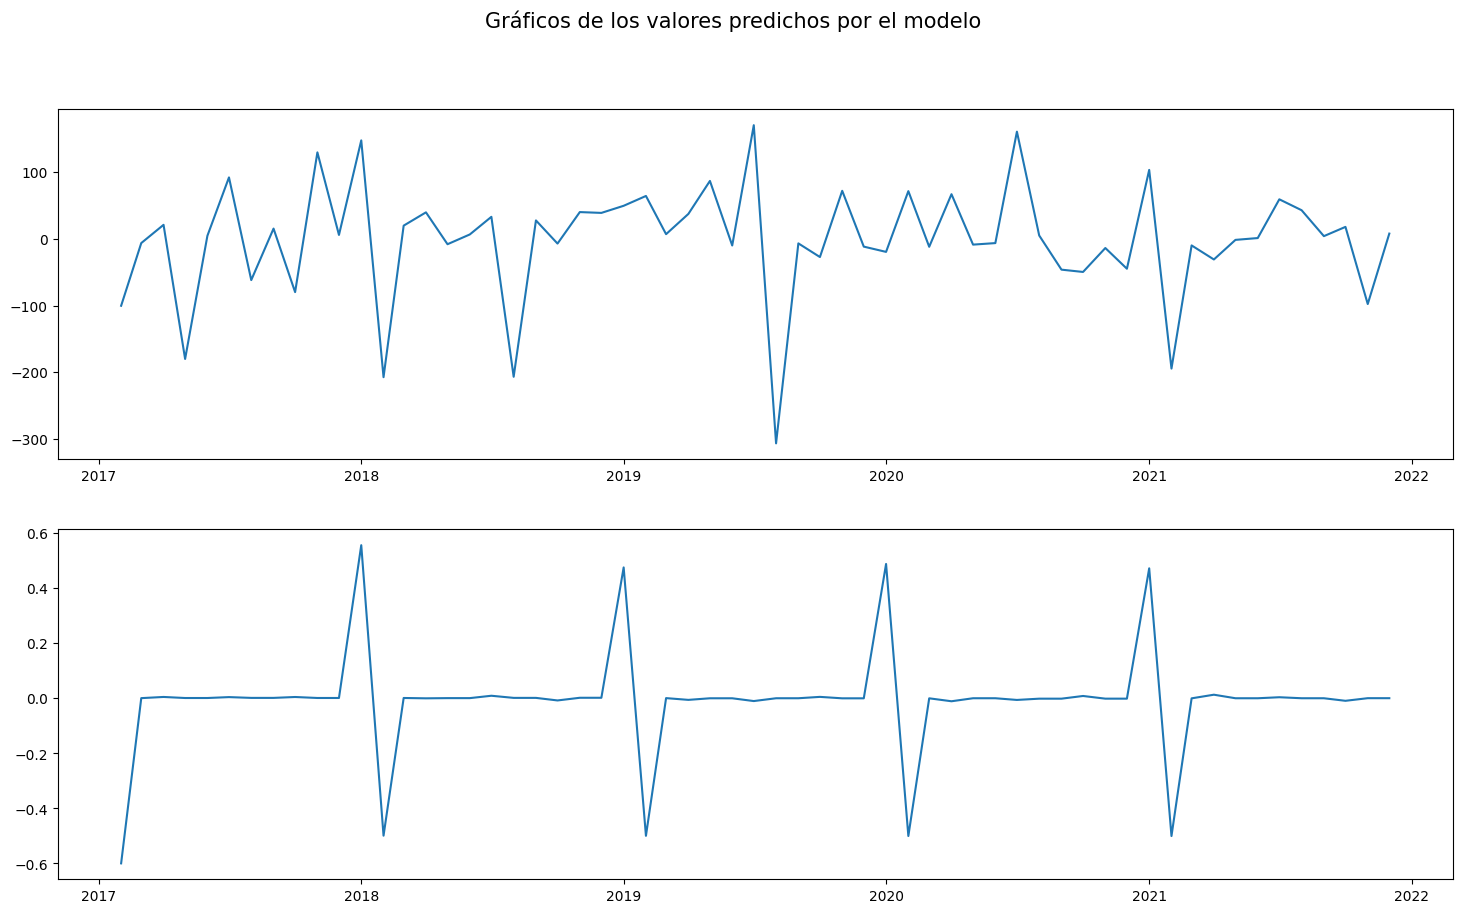

In [41]:
y_fitted = res.fittedvalues
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los valores predichos por el modelo',fontsize=15)
fig.set_size_inches(18, 10)
[axs[i].plot(y_fitted.iloc[:,i]) for i in range(2)]
plt.show()

#### Pronósticos a futuro


In [42]:
# Obtener el orden del modelo
lag_order = res.k_ar
print('Orden del modelo:', lag_order)
# Input data para hacer forecasting (pronósticos a futuro)
input_data = X_train_transformed.values[-lag_order:]
# Forecasting
pred = res.forecast(y=input_data, steps=12)
pred = (pd.DataFrame(pred, index=X_test.index, columns=X_test.columns + '_pred'))
print('Predicciones:')
pred

Orden del modelo: 11
Predicciones:


,Compraventa_Unitario_pred,Estudios_Obligatorios_pred
Fecha,,
2022-01-01,120.134172,0.468979
2022-02-01,-116.033634,-0.468909
2022-03-01,0.144316,0.000016
2022-04-01,-70.118146,0.014908
2022-05-01,67.783840,-0.014743
2022-06-01,0.293165,0.000025
2022-07-01,100.798834,-0.007015
2022-08-01,-88.937315,0.007660
2022-09-01,1.693831,0.000064


<Figure size 1200x1000 with 0 Axes>

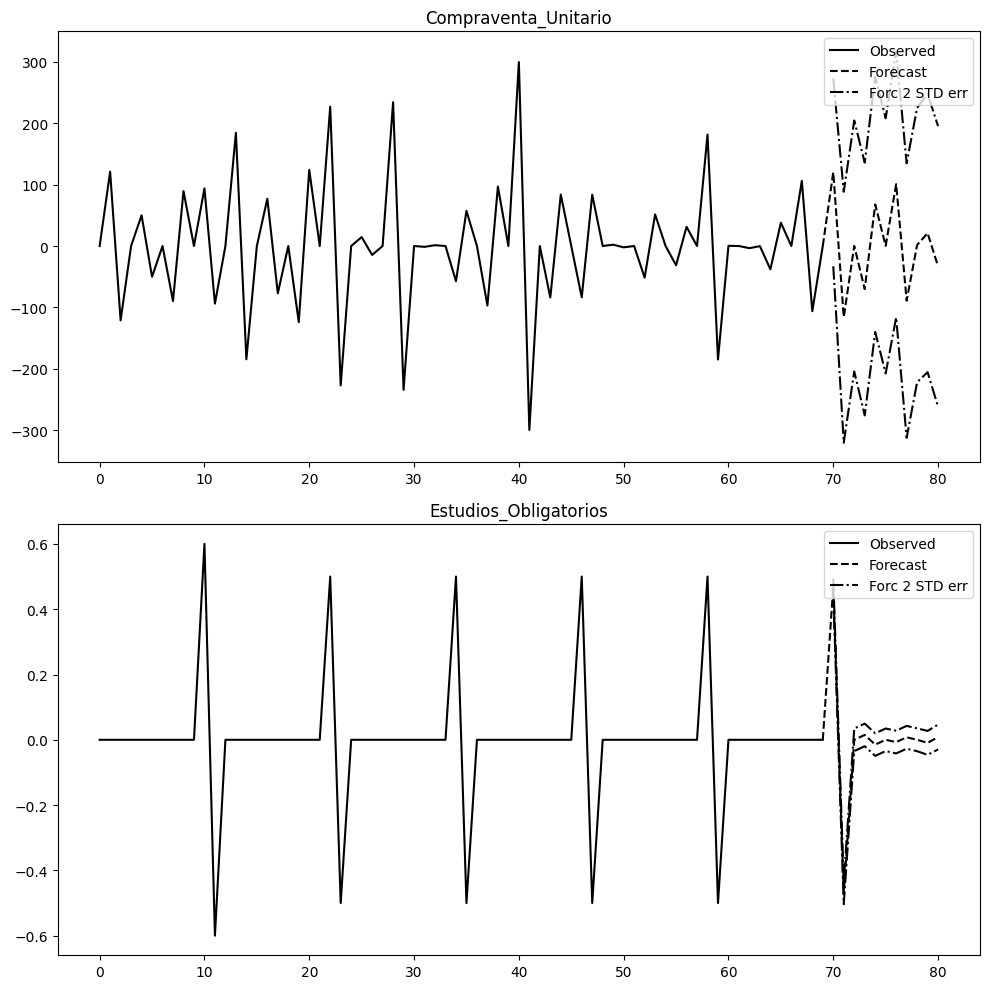

In [43]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12, 10))
res.plot_forecast(lag_order)
plt.tight_layout(h_pad = 1.15)
plt.show()


#### Invirtiendo la transformación de los pronósticos a la escala original


Los pronósticos se generan en la escala de los datos de entrenamiento utilizados por el modelo, es decir, son datos transformados. Entonces, para volver a ponerlos en su escala original, necesitamos des-diferenciarlos. La forma de invertir la diferenciación es sumar estas diferencias consecutivamente al número base. Una forma sencilla de hacerlo es determinar primero la suma acumulada y luego sumarla al número base. Este proceso se puede revertir agregando la observación en el paso de tiempo anterior al difference value. inverted(ts) = differenced(ts) + observation(ts-1)



In [44]:
# Invirtiendo la transformación teniendo en cuenta que hemos diferenciado dos veces
def invert_transformation(ds, df_forecast, second_diff=False):
    for col in ds.columns:
        # Undo the 2nd Differencing
        if second_diff:
            df_forecast[str(col)] = (ds[col].iloc[-1] - ds[col].iloc[-2]) + df_forecast[str(col)].cumsum()

        # Undo the 1st Differencing
        df_forecast[str(col)] = ds[col].iloc[-1] + df_forecast[str(col)].cumsum()

    return df_forecast

In [45]:
pred.columns=X_test.columns
output = invert_transformation(X_train, pred, second_diff=True)
output

,Compraventa_Unitario,Estudios_Obligatorios
Fecha,,
2022-01-01,2499.499850,97.168979
2022-02-01,2497.222257,97.169049
2022-03-01,2495.088979,97.169134
2022-04-01,2422.837556,97.184128
2022-05-01,2418.369973,97.184378
2022-06-01,2414.195554,97.184654
2022-07-01,2510.819969,97.177916
2022-08-01,2518.507070,97.178837
2022-09-01,2527.888001,97.179822


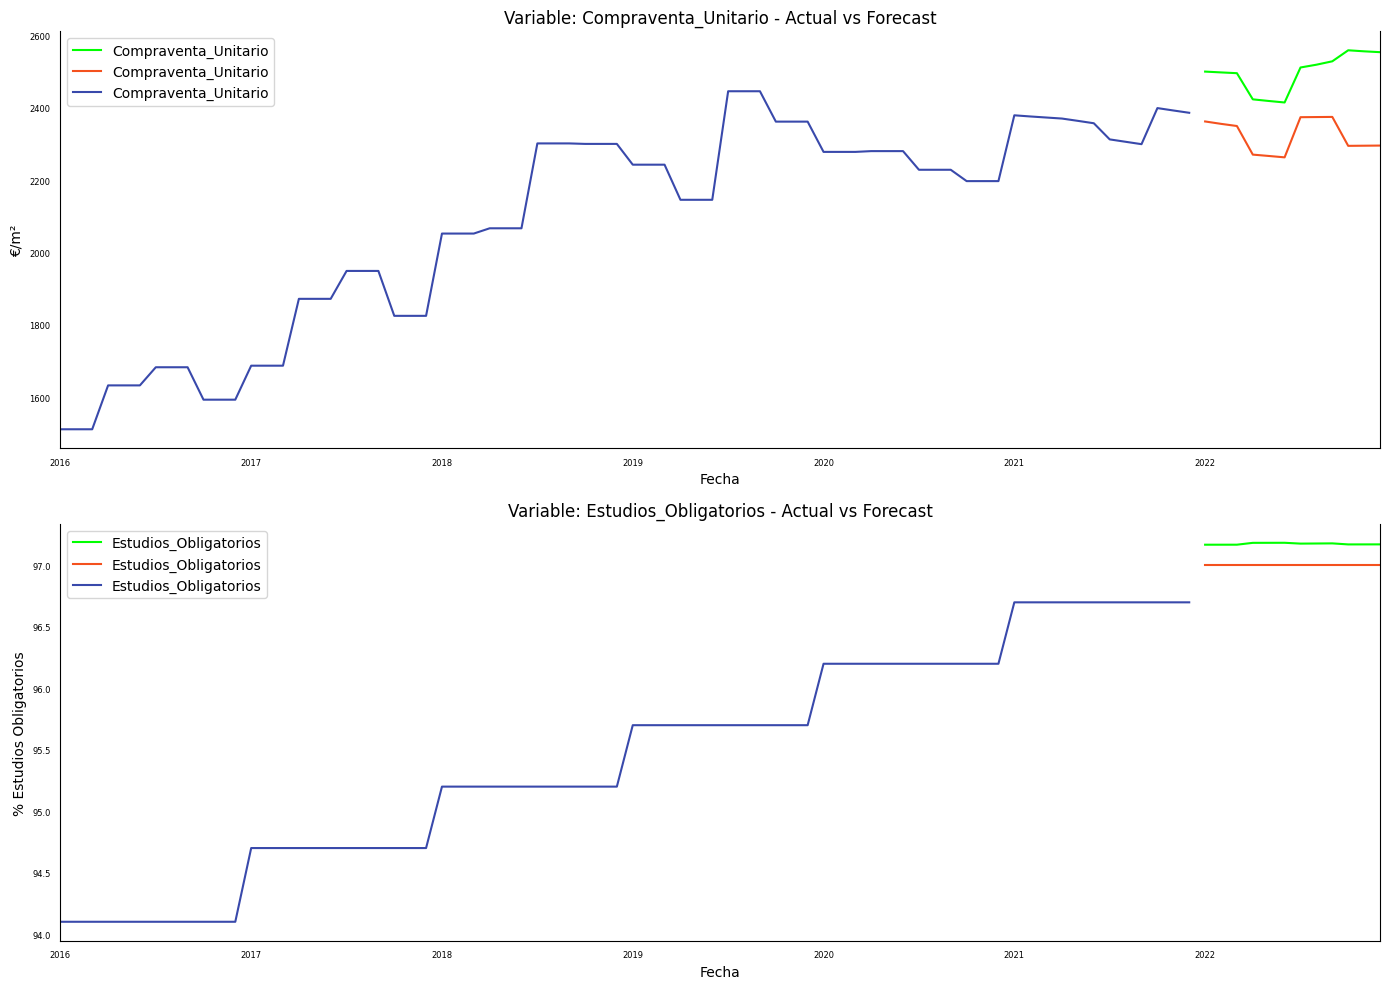

In [46]:
# Actual vs Forecasted Plots
fig, axes = plt.subplots(nrows = int(len(X_train.columns)), ncols = 1, dpi = 100, figsize = (14,10))
mi_lista = ['€/m²', '% Estudios Obligatorios']

for i, (col,ax) in enumerate(zip(X_train.columns, axes.flatten())):
    output[col].plot(color = '#00FF00', legend = True, ax = ax).autoscale(axis =' x',tight = True)
    X_test[col].plot(color = '#F4511E', legend = True, ax = ax)
    X_train[col].plot(color = '#3949AB', legend = True, ax = ax)

    ax.set_title('Variable: ' + col + ' - Actual vs Forecast')
    ax.set_ylabel(mi_lista[i])  # Establecer etiqueta del eje y
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize = 6)

plt.tight_layout()
plt.savefig('actual_forecast.png')
plt.show()

#### Evaluando el modelo


In [47]:
def timeseries_evaluation_metrics_func(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [48]:
for i in ['Compraventa_Unitario','Estudios_Obligatorios']:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(X_test[str(i)] , output[str(i)])

Evaluation metric for Compraventa_Unitario
Evaluation metric results:-
MSE is : 33087.34587791786
MAE is : 174.93419556119363
RMSE is : 181.89927398952932
MAPE is : 7.551288266147742
R2 is : -16.260050578740834

Evaluation metric for Estudios_Obligatorios
Evaluation metric results:-
MSE is : 0.03099736178605431
MAE is : 0.17595595728488078
RMSE is : 0.17606067643302495
MAPE is : 0.1813978941081245
R2 is : 0.0




Los modelos analizados muestran un contraste significativo en su desempeño. Para "Compraventa_Unitario", las métricas indican un rendimiento pobre, con errores altos y un valor R2 extremadamente negativo, lo que sugiere que el modelo es mucho peor que uno basado en la media. En contraste, el modelo para "Estudios_Obligatorios" exhibe errores muy bajos y un MAPE insignificante, pero su R2 de 0 revela que solo predice la media, sin capturar variaciones específicas de los datos. Esto indica precisión en las predicciones pero falta de ajuste a la dinámica de los datos.

In [49]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print('Mean absolute error:', mean_absolute_error(X_test, output))
print('Root mean squared error:', np.sqrt(mean_squared_error(X_test, output)))

Mean absolute error: 87.55507575923926
Root mean squared error: 128.62227037974344


### Modelo VECM (Vector Error Correction Model

In [50]:
!pip install statsmodels==0.14.1

#### Ajustando el modelo

In [51]:
from statsmodels.tsa.vector_ar.vecm import select_order

In [52]:
# Seleccionar el número óptimo de retardos basado en criterios de información
order_selection = select_order(X_train, maxlags=8) #Dado que una de las series tiene datos trimestrales(8) y la otra anual(30)
print(order_selection.summary())

 VECM Order Selection (* highlights the minimums)
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       4.680      4.884*       107.8      4.760*
1       4.791       5.132       120.5       4.925
2       4.900       5.376       134.5       5.087
3       4.875       5.487       131.5       5.116
4       4.963       5.711       144.0       5.257
5       5.033       5.917       155.2       5.381
6      4.641*       5.661      105.5*       5.042
7       4.736       5.892       117.1       5.190
8       4.814       6.106       128.1       5.322
-------------------------------------------------


In [53]:
from statsmodels.tsa.vector_ar.vecm import VECM

In [54]:
# Usar el número óptimo de retardos seleccionado
optimal_lags = order_selection.aic  # Por ejemplo, puedes usar el criterio AIC
model = VECM(X_train, k_ar_diff=optimal_lags, coint_rank=1)

In [55]:
vecm_fit = model.fit()

In [56]:
vecm_fit.summary()

,coef,std err,z,P>|z|,[0.025,0.975]
L1.Compraventa_Unitario,-0.0189,0.109,-0.173,0.863,-0.233,0.195
L1.Estudios_Obligatorios,-39.4795,60.515,-0.652,0.514,-158.086,79.127
L2.Compraventa_Unitario,-0.0189,0.109,-0.172,0.863,-0.233,0.196
L2.Estudios_Obligatorios,-39.4518,60.536,-0.652,0.515,-158.100,79.196
L3.Compraventa_Unitario,-0.3230,0.111,-2.918,0.004,-0.540,-0.106
L3.Estudios_Obligatorios,25.0567,60.878,0.412,0.681,-94.261,144.375
L4.Compraventa_Unitario,-0.0514,0.116,-0.445,0.657,-0.278,0.175
L4.Estudios_Obligatorios,-28.1633,57.158,-0.493,0.622,-140.191,83.864
L5.Compraventa_Unitario,-0.0517,0.116,-0.447,0.655,-0.278,0.175
L5.Estudios_Obligatorios,-28.2955,57.175,-0.495,0.621,-140.356,83.765


El análisis indica que las dos series están cointegradas y tienen una relación dinámica de ajuste hacia un equilibrio común. Los resultados sugieren que ajustes en "Estudios_Obligatorios" tienen un efecto significativo en "Compraventa_Unitario", mientras que los ajustes en "Compraventa_Unitario" tienen un impacto relativamente menor en "Estudios_Obligatorios" basado en los coeficientes de carga más pequeños.

In [57]:
stability_test = vecm_fit.test_whiteness(nlags=12)
print(stability_test.summary())

Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 12 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         28.31          33.92   0.166 22
----------------------------------------


#### Diagnosis del modelo


#####Residuos

In [58]:
residuals=vecm_fit.resid

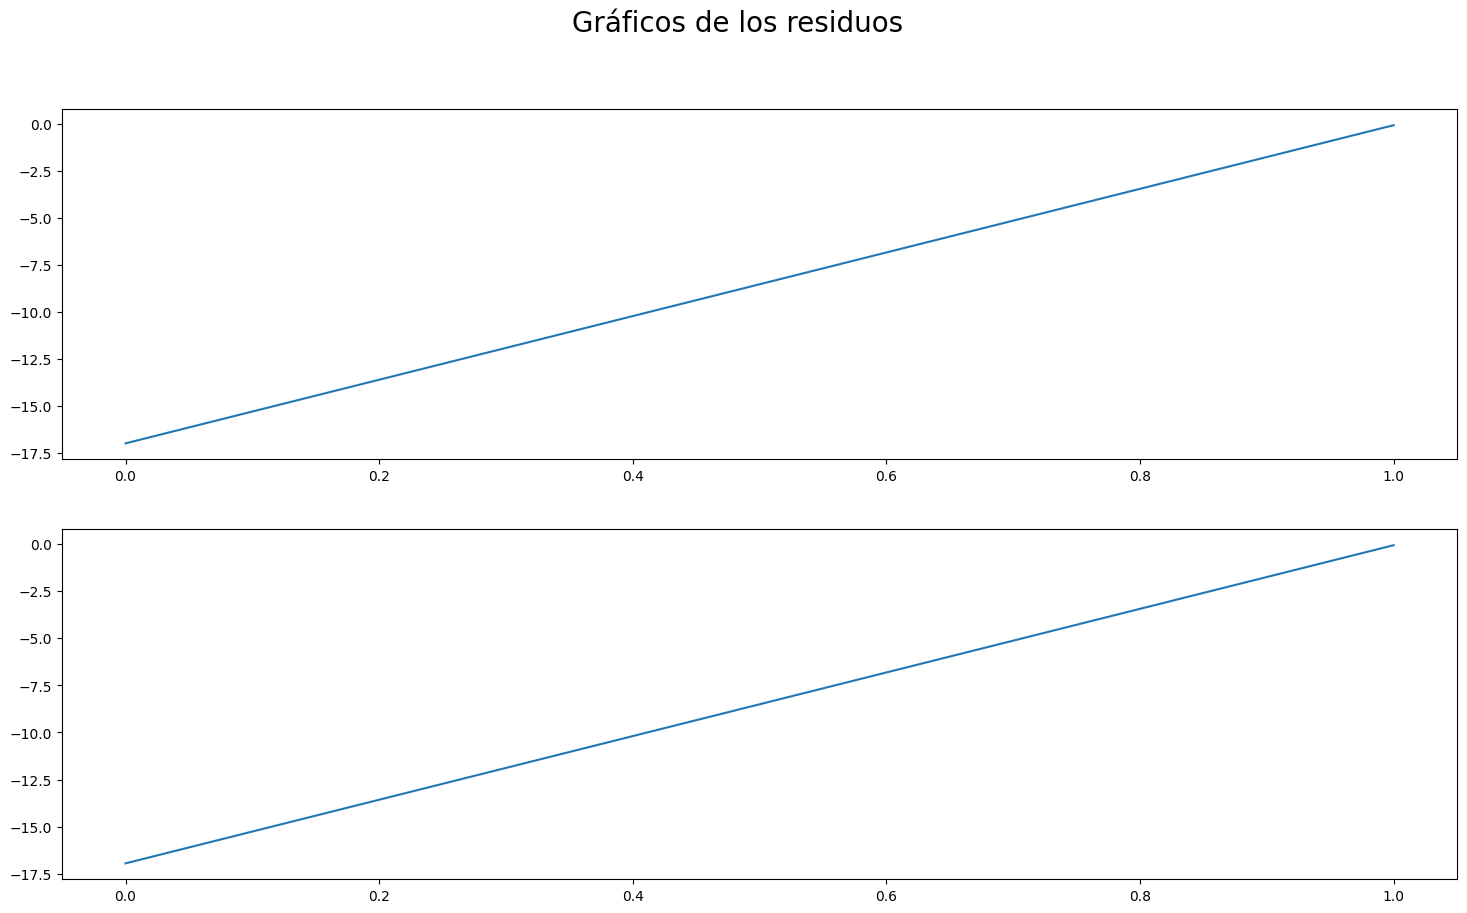

In [59]:
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los residuos',fontsize=20)
fig.set_size_inches(18, 10)
[axs[i].plot(residuals[i]) for i in range(2)]
plt.show()

##### Dickey - Fuller a los residuos


In [60]:
import statsmodels.tsa.stattools as ts

In [61]:
# Realizar la prueba ADF en cada serie de residuos y imprimir los resultados
print('ADF de los Residuos, p-valores:')
for i in range(residuals.shape[1]):
    result = ts.adfuller(residuals[:, i])
    print(f'Variable {i+1}: Estadístico ADF = {result[0]:.4f}, P-valor = {result[1]:.4f}')

ADF de los Residuos, p-valores:
Variable 1: Estadístico ADF = -7.7002, P-valor = 0.0000
Variable 2: Estadístico ADF = -2.7632, P-valor = 0.0637


Todos los p-valores son < 0.1 por tanto se rechaza la hipótesis nula de que las 2 series de residuos no son estacionarias, por lo cual con un 90% de confianza se cree que son estacionarias.

#####ACF de los Residuos

In [62]:
import statsmodels.api as sm

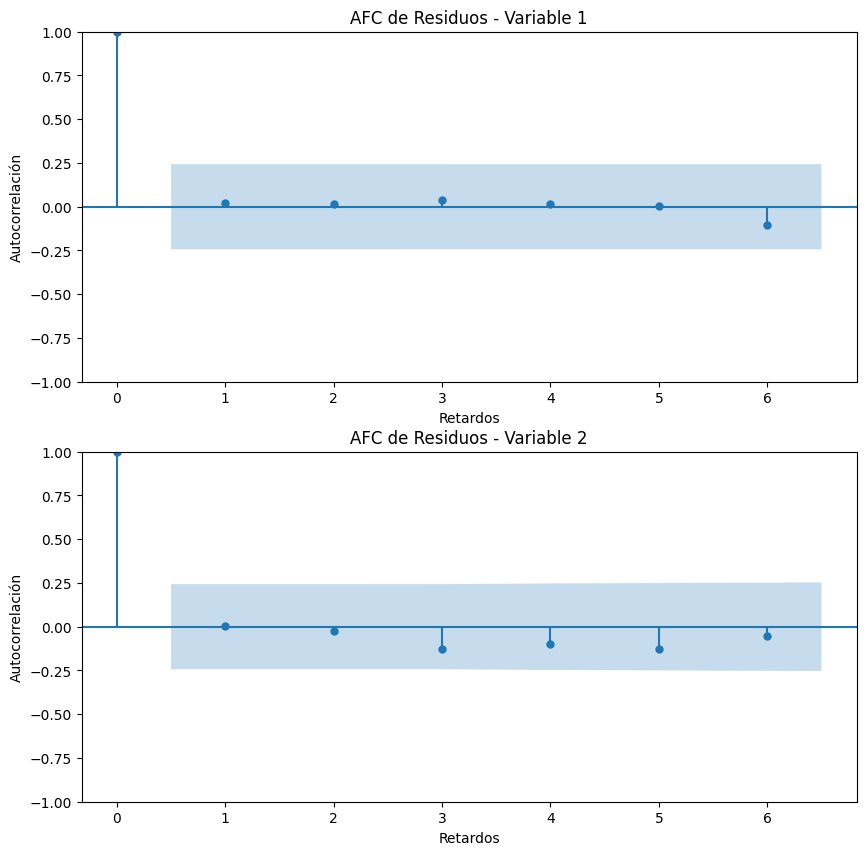

In [63]:
# Realizar y graficar la función de autocorrelación para cada serie de residuos
fig, axes = plt.subplots(nrows=residuals.shape[1], ncols=1, figsize=(10, 10))
for i in range(residuals.shape[1]):
    sm.graphics.tsa.plot_acf(residuals[:, i], lags=6, ax=axes[i], title=f'AFC de Residuos - Variable {i+1}')
    axes[i].set_ylabel('Autocorrelación')
    axes[i].set_xlabel('Retardos')

Esto sugiere que los residuos de la Variable 1  y 2 son aproximadamente ruido blanco, indicando un buen ajuste del modelo para esta variable. No hay evidencia de autocorrelaciones remanentes que el modelo no haya capturado.


#### Valores predichos

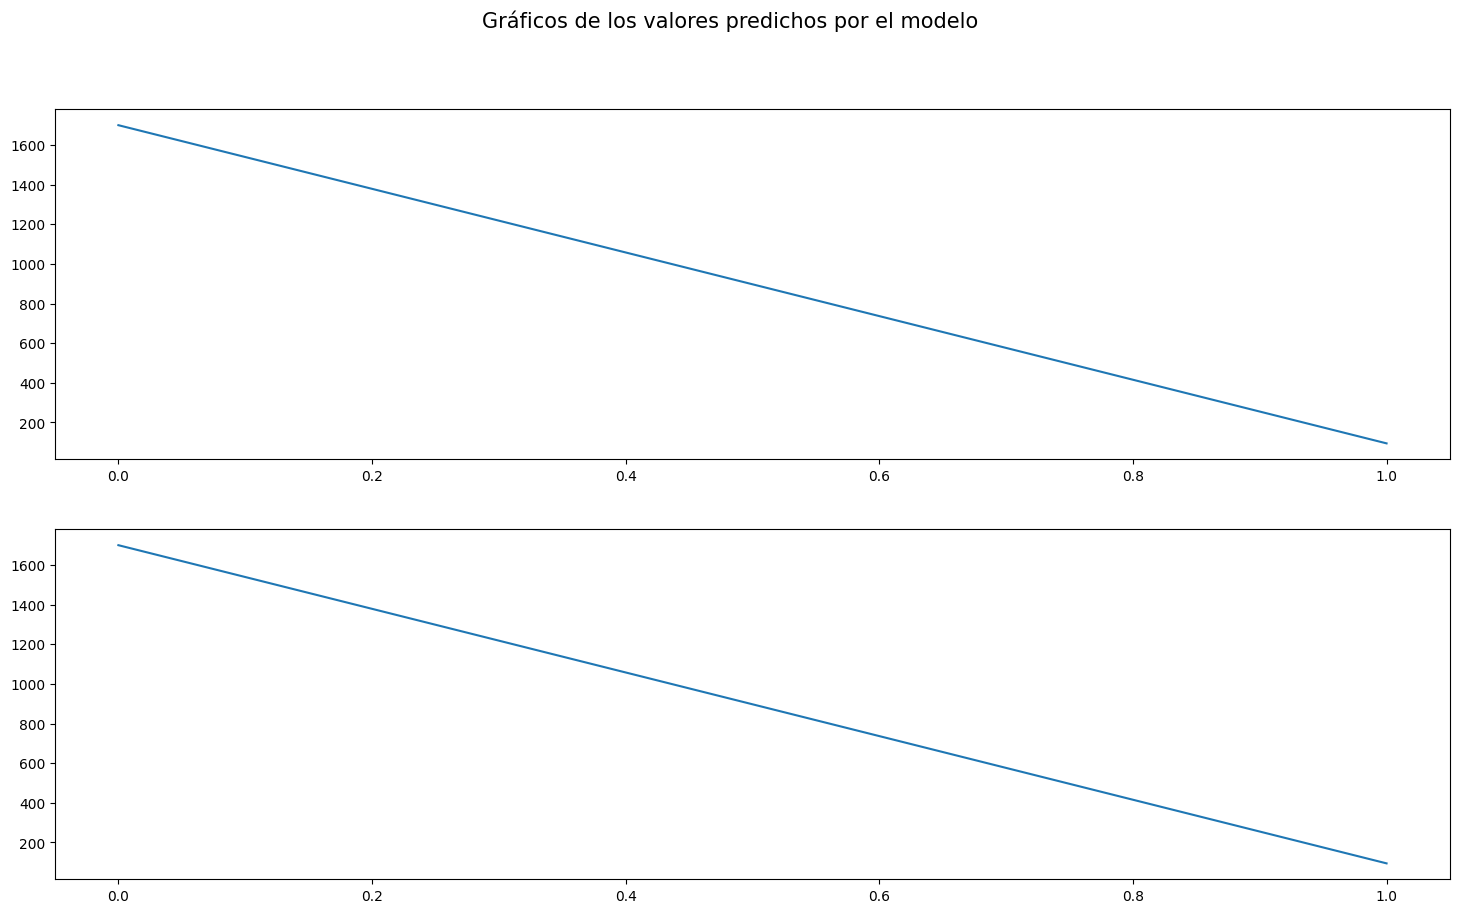

In [64]:
y_fitted = vecm_fit.fittedvalues
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los valores predichos por el modelo',fontsize=15)
fig.set_size_inches(18, 10)
[axs[i].plot(y_fitted[i]) for i in range(2)]
plt.show()

#### Pronósticos a futuro


In [65]:
# Obtener los últimos valores (lag_order número de valores)
lag_order = vecm_fit.k_ar
last_observations = data[-lag_order:]

# Hacer predicciones para los próximos n pasos
n_steps = 12
forecast = vecm_fit.predict(n_steps)

pred = (pd.DataFrame(forecast, index=X_test.index, columns=X_test.columns))
pred

,Compraventa_Unitario,Estudios_Obligatorios
Fecha,,
2022-01-01,2381.249080,96.672944
2022-02-01,2395.842850,96.711918
2022-03-01,2408.184909,96.742860
2022-04-01,2391.588951,96.864322
2022-05-01,2399.148114,96.889607
2022-06-01,2405.203573,96.908744
2022-07-01,2417.458854,96.957032
2022-08-01,2426.524321,96.983999
2022-09-01,2434.718884,97.011035


<Figure size 1200x1000 with 0 Axes>

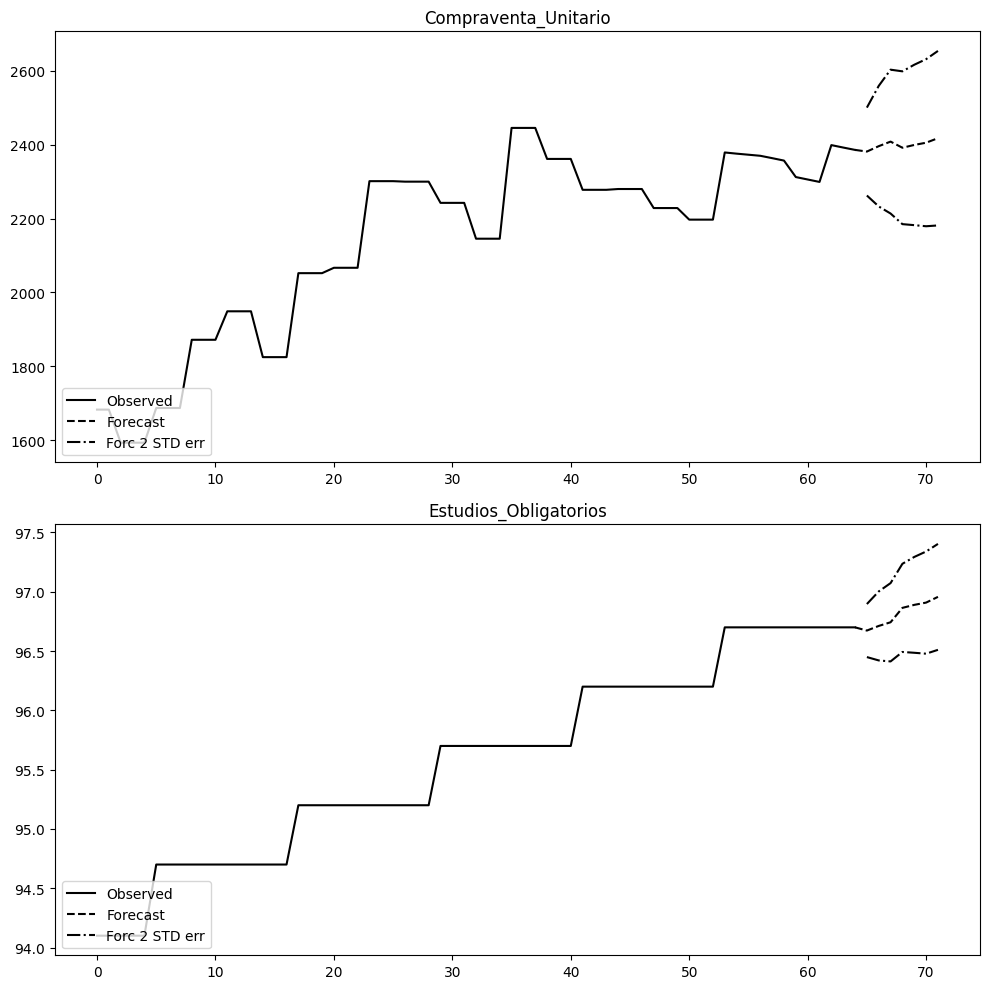

In [66]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12, 10))
vecm_fit.plot_forecast(lag_order)
plt.tight_layout(h_pad = 1.15)
plt.show()

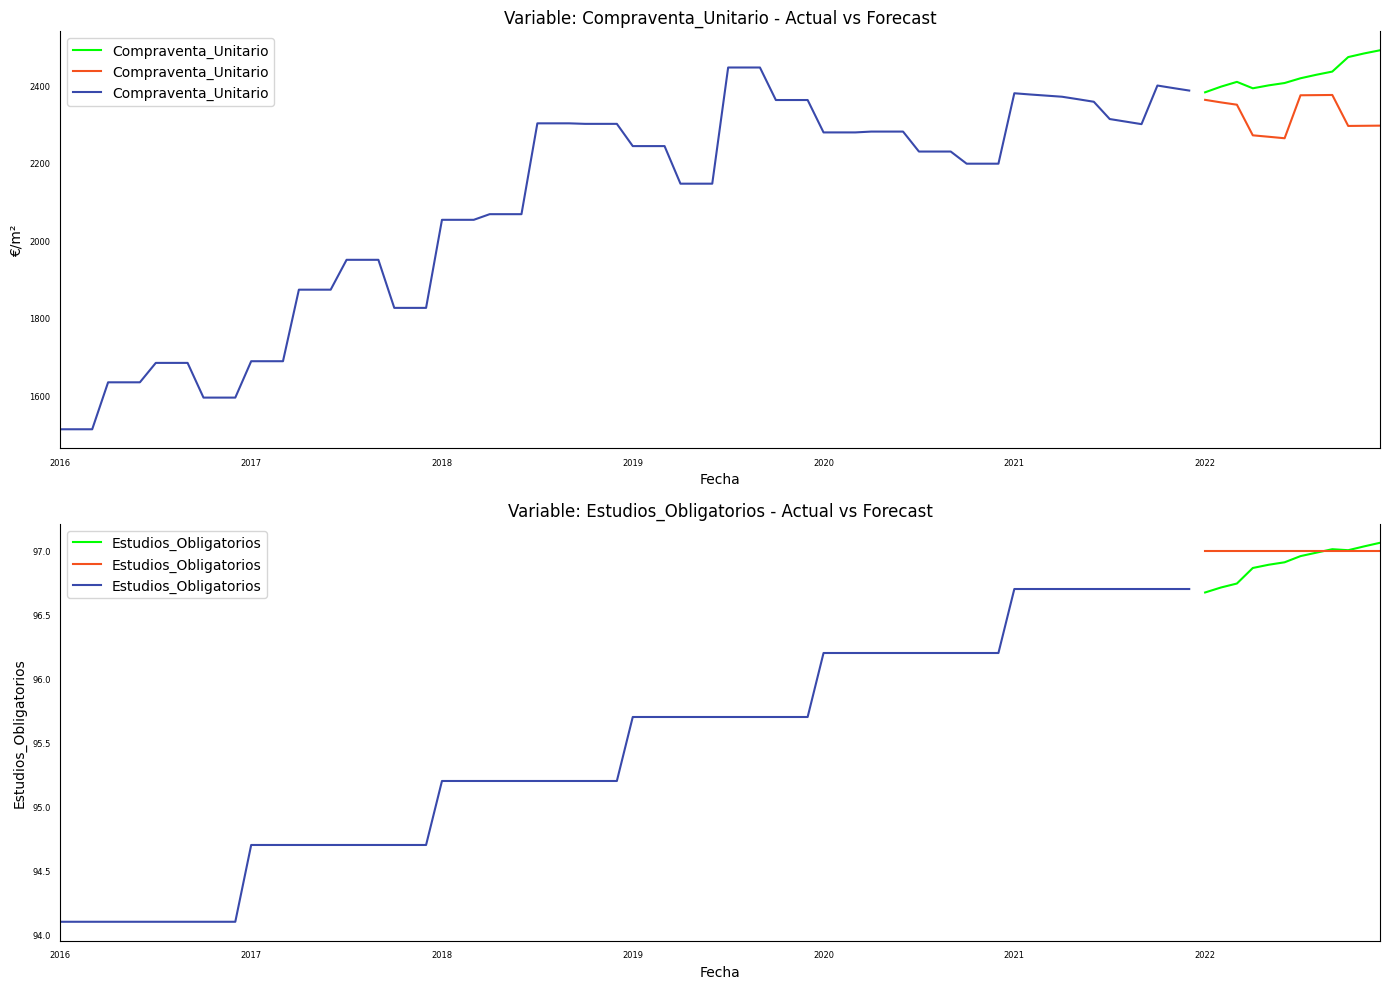

In [67]:
# Actual vs Forecasted Plots
fig, axes = plt.subplots(nrows = int(len(X_train.columns)), ncols = 1, dpi = 100, figsize = (14,10))
mi_lista = ['€/m²', 'Estudios_Obligatorios']

for i, (col,ax) in enumerate(zip(X_train.columns, axes.flatten())):
    pred[col].plot(color = '#00FF00', legend = True, ax = ax).autoscale(axis =' x',tight = True)
    X_test[col].plot(color = '#F4511E', legend = True, ax = ax)
    X_train[col].plot(color = '#3949AB', legend = True, ax = ax)

    ax.set_title('Variable: ' + col + ' - Actual vs Forecast')
    ax.set_ylabel(mi_lista[i])  # Establecer etiqueta del eje y
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize = 6)

plt.tight_layout()
plt.savefig('actual_forecast.png')
plt.show()

#### Evaluando el modelo

In [68]:
def timeseries_evaluation_metrics_func(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [69]:
for i in ['Compraventa_Unitario','Estudios_Obligatorios']:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(X_test[str(i)] , pred[str(i)])

Evaluation metric for Compraventa_Unitario
Evaluation metric results:-
MSE is : 14222.60127785212
MAE is : 102.59297417715247
RMSE is : 119.25854802844164
MAPE is : 4.458986677303198
R2 is : -6.419235689763325

Evaluation metric for Estudios_Obligatorios
Evaluation metric results:-
MSE is : 0.025172221088948576
MAE is : 0.11474296044708392
RMSE is : 0.1586575591925849
MAPE is : 0.11829171180111743
R2 is : 0.0



El modelo para "Compraventa_Unitario" muestra un alto error con un MSE de 34443.2478 y un R² negativo de -16.967, indicando un rendimiento muy pobre. Por otro lado, "Estudios_Obligatorios" tiene errores mínimos con un MSE de 0.0288 y un MAPE de 0.175%, pero un R² de 0.0, sugiriendo que solo predice la media de los datos. En resumen, el modelo de "Compraventa_Unitario" necesita mejoras significativas, mientras que el de "Estudios_Obligatorios" es preciso pero no explica la variabilidad.

In [70]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print('Mean absolute error:', mean_absolute_error(X_test, pred))
print('Root mean squared error:', np.sqrt(mean_squared_error(X_test, pred)))

Mean absolute error: 51.35385856879978
Root mean squared error: 84.32860265080055


##Conclusiones

Como conclusiones de realizar un analisis de datos forecasting a los datos de distrito de **Nou Barris** de Barcelona entre las dos series temporales de Compraventa_Unitario y estudios obligatorios tenemos que:

- Se ha comprobado que las variables tienen una alta correlacion.
- Se ha realizado el test de Cointegracion y se ha demostrado que una de las series Compraventa_unitario esta cointegrada, lo que hace mas adecuado aplicar un modelo VECM, que un modelo VARMA
- Se ha comprobado que la dos series de datos temporales tienen estacionalidad, con una diferenciacion de segunda orden lo que las hace aptas para aplicar los dos modelos VAR

- Modelo VAR: las metricas de evaluación del modelo VAR, son bastante satisfactorias para la serie temporal de estudios obligatorios y no tanto para la serie temporal de Compraventa_unitario
- Modelo VECM: las metricas de evaluación del modelo VECM, son bastante satisfactorias para la serie temporal de estudios obligatorios y no tanto para la serie temporal de Compraventa_unitario.


